In [ ]:
import torch
from torch import nn
from d2l import torch as d2l
import os
from torch.optim import lr_scheduler
import re

In [5]:
def tokenize(lines, token='word'):
    """Split text lines into word or character tokens.
    Defined in :numref:`sec_text_preprocessing`"""
    filters = ['!', '"', '#', '$', '%', '&', '\(', '\)', '\*', '\+', ',', '-', '\.', '/', ':', ';', '<', '=', '>',
                '\?', '@', '\[', '\\', '\]', '^', '_', '`', '\{', '\|', '\}', '~', '\t', '\n', '\x97', '\x96', '”',
                '“', ]
    cleaner = re.compile('<.*?>')
    stopwords = []
    res = []
    # with open('../data/stopwords.txt', 'r') as f:
    #     for line in f.readlines():
    #         stopwords.append(line.strip())
    if token == 'word':
        for line in lines:
            line = re.sub(cleaner, ' ', line)
            line = re.sub("|".join(filters), '', line)
            res.append(line.split())
        return res
    elif token == 'char':
        return [list(line) for line in lines]
    else:
        print('ERROR: unknown token type: ' + token)


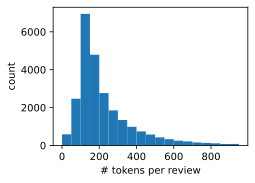

In [6]:
def load_data_imdb(batch_size, num_steps=500):
    """Return data iterators and the vocabulary of the IMDb review dataset.

    Defined in :numref:`sec_sentiment`"""
    data_dir = "./datasets/aclImdb"
    train_data = d2l.read_imdb(data_dir, True)
    test_data = d2l.read_imdb(data_dir, False)
    train_tokens = tokenize(train_data[0], token='word')
    d2l.set_figsize()
    d2l.plt.xlabel('# tokens per review')
    d2l.plt.ylabel('count')
    d2l.plt.hist([len(line) for line in train_tokens], bins=range(0, 1000, 50));
    test_tokens = tokenize(test_data[0], token='word')
    vocab = d2l.Vocab(train_tokens, min_freq=5)
    train_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in train_tokens])
    test_features = torch.tensor([d2l.truncate_pad(
        vocab[line], num_steps, vocab['<pad>']) for line in test_tokens])
    train_iter = d2l.load_array((train_features, torch.tensor(train_data[1])),
                                batch_size)
    test_iter = d2l.load_array((test_features, torch.tensor(test_data[1])),
                               batch_size,
                               is_train=False)
    return train_iter, test_iter, vocab
batch_size = 100
train_iter, test_iter, vocab = load_data_imdb(batch_size)

In [7]:
class Model(nn.Module):
    def __init__(self, **params):
        super(Model, self).__init__()
        vocab_size = params['vocab_size']
        embed_size = params['embed_size']
        kernel_sizes = params['kernel_size']
        num_channels = params['num_channels']
        num_heads = params['num_heads']
        num_layers = params['num_layers']
        num_hidden = params['num_hidden']
        dropout_pro = params['dropout_pro']
        self.embedding = nn.Embedding(vocab_size, embed_size)
        # 这个嵌入层不需要训练
        self.constant_embedding = nn.Embedding(vocab_size, embed_size)
        self.dropout = nn.Dropout(dropout_pro)
        # 最大时间汇聚层没有参数，因此可以共享此实例
        self.pool = nn.AdaptiveAvgPool1d(1)
        self.relu = nn.ReLU()
        # 创建多个一维卷积层
        self.convs = nn.ModuleList()
        for c, k in zip(num_channels, kernel_sizes):
            self.convs.append(nn.Conv1d(2 * embed_size, c, k))
        # textcnn attention
        self.attention1 = nn.MultiheadAttention(embed_dim=sum(num_channels), num_heads=num_heads, dropout=dropout_pro, batch_first=True)
        self.rnn = nn.LSTM(input_size=2*embed_size, hidden_size=num_hidden, num_layers=num_layers, dropout=dropout_pro, batch_first=True, bidirectional=True)
        # lstm attention
        self.attention2 = nn.MultiheadAttention(embed_dim=2*num_hidden, num_heads=num_heads, dropout=dropout_pro, batch_first=True)
        self.flatten = nn.Flatten()
        self.decoder = nn.Linear((2*num_hidden+sum(num_channels))*500, 2)

    def forward(self, inputs):
        # 沿着向量维度将两个嵌入层连结起来，
        # embeddings 形状（批量大小，词元数量，2*embed_size）连结起来
        embeddings = torch.cat((
            self.embedding(inputs), self.constant_embedding(inputs)), dim=2)
        # 根据一维卷积层的输入格式，重新排列张量，以便通道作为第2维
        # embeddings1 的形状为（批量大小，2*embed_size, 词元数量）
        embeddings1 = embeddings.permute(0, 2, 1)
        # 每个一维卷积层在最大时间汇聚层合并后，获得的张量形状是（批量大小，num_channels，词元数量）
        # encoding 形状为 (批量大小，3*num_channels, 词元数量)
        encoding = torch.cat([
            self.relu(nn.ZeroPad2d(padding=(0, conv.kernel_size[0]-1, 0, 0 ))(conv(embeddings1)))
            for conv in self.convs], dim=1)
        # encoding 形状为（批量大小，词元数量, 3*num_channels）
        encoding = encoding.permute(0, 2, 1)
        # print(f"encoding.shape:{encoding.shape}")
        # atten_output1 形状为（批量大小，词元数量, 3*num_channels）
        atten_output1, _ = self.attention1(encoding, encoding, encoding)
        # lstm-attention
        lstm, _ = self.rnn(embeddings)
        # lstm 形状（批量大小，词元数量，num_hiddens）
        # atten_output2 的形状为（批量大小，词元数量，num_hiddens）
        atten_output2, _ = self.attention2(lstm, lstm, lstm)
        inputs = torch.cat((atten_output1, atten_output2), dim=2)
        # inputs 形状：(批量大小，词元数量，num_hiddens+sum(num_channels))
        return self.decoder(self.flatten(inputs))

In [8]:
import numpy as np
from gensim.models import KeyedVectors
word_vectors = KeyedVectors.load_word2vec_format("../CNN-sentence-classification-pytorch/GoogleNews-vectors-negative300.bin", binary=True)
# 遍历数据集词库，如果有相应的词向量则添加至wv_matrix, 没有则使用均值分布初始化
wv_matrix = []
for i in range(len(vocab)):
    word = vocab.idx_to_token[i]
    if word in word_vectors.key_to_index:
        wv_matrix.append(word_vectors.get_vector(word))
    else:
        wv_matrix.append(np.random.uniform(-0.01, 0.01, 300).astype("float32"))

# one for UNK and one for zero padding
# wv_matrix.append(np.random.uniform(-0.01, 0.01, 300).astype("float32"))
# wv_matrix.append(np.zeros(300).astype("float32"))
wv_matrix = torch.tensor(np.array(wv_matrix))

In [29]:
def train(net, train_iter, test_iter, loss, trainer, num_epochs,
               devices, scheduler=None):
    """Train a model with mutiple GPUs (defined in Chapter 13).

    Defined in :numref:`sec_image_augmentation`"""
    test_accs = []
    timer, num_batches = d2l.Timer(), len(train_iter)
    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                            legend=['train loss', 'train acc', 'test acc'])
    # net = nn.DataParallel(net, device_ids=devices).to(devices[0])
    net = net.to(devices[0])
    for epoch in range(num_epochs):
        # Sum of training loss, sum of training accuracy, no. of examples,
        # no. of predictions
        metric = d2l.Accumulator(4)
        for i, (features, labels) in enumerate(train_iter):
            timer.start()
            l, acc = d2l.train_batch_ch13(
                net, features, labels, loss, trainer, devices)
            metric.add(l, acc, labels.shape[0], labels.numel())
            timer.stop()
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:
                animator.add(epoch + (i + 1) / num_batches,
                             (metric[0] / metric[2], metric[1] / metric[3],
                              None))
        if scheduler:
                if scheduler.__module__ == lr_scheduler.__name__:
                    # UsingPyTorchIn-Builtscheduler
                    scheduler.step()
                else:
                    # Usingcustomdefinedscheduler
                    for param_group in trainer.param_groups:
                        param_group['lr'] = scheduler(epoch)
        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch + 1, (None, None, test_acc))
        test_accs.append(test_acc)
    print(f'loss {metric[0] / metric[2]:.3f}, train acc '
          f'{metric[1] / metric[3]:.3f}, test acc {test_acc:.3f}')
    print(f'{metric[2] * num_epochs / timer.sum():.1f} examples/sec on '
          f'{str(devices)}')
    print(test_accs)
    return net

In [10]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

loss 0.138, train acc 0.951, test acc 0.900
230.2 examples/sec on [device(type='cuda', index=0)]
[0.89052, 0.89956, 0.89964]


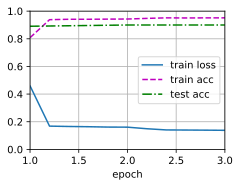

In [219]:
lr, num_epochs = 0.001, 3
param = {"vocab_size":len(vocab), "embed_size":300, "kernel_size":[2, 3, 4], "num_channels":[100, 100, 100], "num_heads":4, "num_layers":3, "dropout_pro":0.5, "num_hidden":256}
devices = d2l.try_all_gpus()
net = Model(**param)
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.requires_grad = False
trainer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler1 = lr_scheduler.MultiStepLR(trainer, milestones=[1, 2], gamma=0.1)
scheduler2 = FactorScheduler(factor=0.8, stop_factor_lr=1e-7, base_lr=lr)

loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices, scheduler=scheduler1)

loss 0.121, train acc 0.958, test acc 0.900
230.4 examples/sec on [device(type='cuda', index=0)]
[0.90084, 0.9006, 0.90112, 0.90096, 0.901, 0.90064, 0.90044, 0.90076, 0.89996, 0.90044]


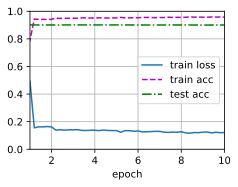

In [11]:
lr, num_epochs = 0.001, 10
param = {"vocab_size":len(vocab), "embed_size":300, "kernel_size":[2, 3, 4], "num_channels":[100, 100, 100], "num_heads":4, "num_layers":3, "dropout_pro":0.5, "num_hidden":256}
devices = d2l.try_all_gpus()
net = Model(**param)
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.requires_grad = False
trainer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler1 = lr_scheduler.MultiStepLR(trainer, milestones=[1, 2], gamma=0.1)
scheduler2 = FactorScheduler(factor=0.8, stop_factor_lr=1e-7, base_lr=lr)

loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices, scheduler=scheduler1)

loss 0.128, train acc 0.956, test acc 0.901
232.1 examples/sec on [device(type='cuda', index=0)]
[0.89524, 0.90172, 0.90072, 0.90088, 0.90044, 0.90064, 0.90056, 0.9006, 0.90056, 0.9006]


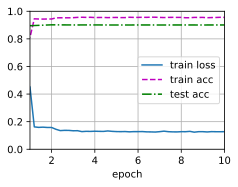

In [12]:
lr, num_epochs = 0.001, 10
param = {"vocab_size":len(vocab), "embed_size":300, "kernel_size":[2, 3, 4], "num_channels":[100, 100, 100], "num_heads":4, "num_layers":3, "dropout_pro":0.5, "num_hidden":256}
devices = d2l.try_all_gpus()
net = Model(**param)
def init_weights(m):
    if type(m) in (nn.Linear, nn.Conv1d):
        nn.init.xavier_uniform_(m.weight)
net.apply(init_weights)
net.embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.data.copy_(wv_matrix)
net.constant_embedding.weight.requires_grad = False
trainer = torch.optim.Adam(net.parameters(), lr=lr)
scheduler1 = lr_scheduler.MultiStepLR(trainer, milestones=[1, 2, 4, 6], gamma=0.1)
scheduler2 = FactorScheduler(factor=0.8, stop_factor_lr=1e-7, base_lr=lr)

loss = nn.CrossEntropyLoss(reduction="none")
train(net, train_iter, test_iter, loss, trainer, num_epochs, devices, scheduler=scheduler1)